# Análisis y limpieza de datos 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata 
import re

df = pd.read_csv("netflix.csv")



Filas: 7787  Columnas: 12


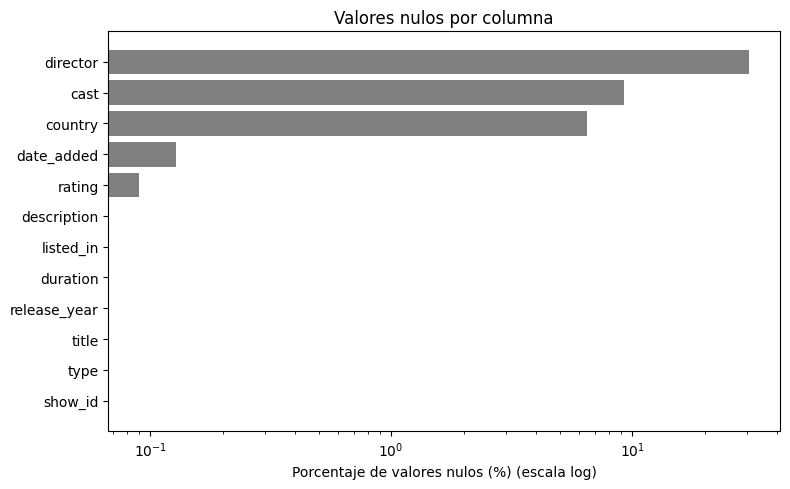

/var/folders/w5/r4237v9175jgsj0grkn8tkhr0000gn/T/ipykernel_68879/892073074.py:46: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_copy['date_added'] = pd.to_datetime(df_copy['date_added'], errors='coerce', dayfirst=False, infer_datetime_format=True)
/var/folders/w5/r4237v9175jgsj0grkn8tkhr0000gn/T/ipykernel_68879/892073074.py:91: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_copy['type'] = df_copy['type'].replace({'Tv Show': 'TV Show', 'Tv show': 'TV Show', 'Tv Show': 'TV Show'})


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration_value,duration_unit,country_list
1485,s1486,Movie,Consequences,Ozan Açıktan,"Nehir Erdoğan, Tardu Flordun, İlker Kaleli, Se...",Turkey,2019-10-25,2014,TV-MA,106 min,"Dramas, International Movies, Thrillers",Secrets bubble to the surface after a sensual ...,106,min,NaN
1486,s1487,Movie,Consequences,Ozan Açıktan,"Nehir Erdoğan, Tardu Flordun, İlker Kaleli, Se...",Turkey,2019-10-25,2014,TV-MA,106 min,"Dramas, International Movies, Thrillers",Secrets bubble to the surface after a sensual ...,106,min,NaN
7458,s7459,Movie,Waiting,Anu Menon,"Naseeruddin Shah, Kalki Koechlin, Rajat Kapoor...",India,2018-05-01,2015,TV-MA,94 min,"Dramas, International Movies",While visiting his comatose wife in the hospit...,94,min,NaN
7460,s7461,Movie,Waiting,Rob McKittrick,"Ryan Reynolds, Anna Faris, Justin Long, David ...",United States,2020-09-23,2005,R,94 min,"Comedies, Independent Movies",Employees turn up the antics during an eight-h...,94,min,NaN


Antes: 7787 | Después: 7785
Estandarización completada


/var/folders/w5/r4237v9175jgsj0grkn8tkhr0000gn/T/ipykernel_68879/892073074.py:111: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_copy_merged = df_copy.groupby(keys, dropna=False, as_index=False).apply(merge_group).reset_index(drop=True)


In [2]:
# Diccionario para valores que representan NaN
null_like = ["", " ", "na", "n/a", "na. ", "none", "null", "nan", "not available", 
"no data", "no aplica", "no aplica.", "sin dato", "sin datos", "desconocido", "N/A", 
"NA", "NULL", "Nan", "-", "--", "?", "s/d", "sd",]

# Caracteres invisibles/unicode problemáticos a eliminar
INVISIBLE_CHARS = ["\u200b", "\u200c", "\u200d", "\ufeff"]

def strip_invisible(text):
    if not isinstance(text, str):
        return text
    cleaned = unicodedata.normalize("NFKC", text)

    for ch in INVISIBLE_CHARS:
        cleaned = cleaned.replace(ch, "")

    cleaned = cleaned.strip().strip(".")
    cleaned = re.sub(r'^[#\-\*\~]+', '', cleaned)
    cleaned = re.sub(r'[#\-\*\~]+$', '', cleaned)

    return cleaned

# Limpieza de strings
for col in df.columns:
    df[col] = df[col].map(strip_invisible)
    df[col] = df[col].replace(null_like + [None], np.nan)

print("Filas:", len(df), " Columnas:", len(df.columns))

# Valores nulos por columna
null_pct = (df.isna().mean() * 100).sort_values()

plt.figure(figsize=(8, 5))
plt.barh(null_pct.index, null_pct.values, color='gray')
plt.xscale('log')  # Escala logarítmica en el eje X

plt.xlabel('Porcentaje de valores nulos (%) (escala log)')
plt.title('Valores nulos por columna')
plt.tight_layout()
plt.show()

df_copy = df.copy()

# Arreglo de fechas 
if 'date_added' in df_copy.columns:
    df_copy['date_added'] = pd.to_datetime(df_copy['date_added'], errors='coerce', dayfirst=False, infer_datetime_format=True)

# Arreglo años de lanzamiento
if 'release_year' in df_copy.columns:
    df_copy['release_year'] = pd.to_numeric(df_copy['release_year'], errors='coerce').astype('Int64')

# Estandarización de unidades de la duración
if 'duration' in df_copy.columns:
    m = df_copy['duration'].str.extract(r'(?P<duration_value>\d+)\s*(?P<duration_unit>\w+)', expand=True)
    df_copy['duration_value'] = pd.to_numeric(m['duration_value'], errors='coerce').astype('Int64')
    df_copy['duration_unit'] = m['duration_unit'].str.lower()

    df_copy['duration_unit'] = df_copy['duration_unit'].replace({
        'mins': 'min', 'minute': 'min', 'minutes': 'min',
        'season': 'season', 'seasons': 'season'
    })

# Campos categóricos comunes
for cat_col in ['type', 'rating']:
    if cat_col in df_copy.columns:
        df_copy[cat_col] = df_copy[cat_col].str.strip()
        if cat_col == 'type':
            df_copy[cat_col] = df_copy[cat_col].str.title()  
        elif cat_col == 'rating':
            df_copy[cat_col] = df_copy[cat_col].str.upper() 
        df_copy[cat_col] = df_copy[cat_col].astype('category')

# Países
if 'country' in df_copy.columns:
    df_copy['country'] = df_copy['country'].str.replace(';', ',', regex=False)
    df_copy['country_list'] = df_copy['country'].str.split(',').map(lambda lst: [x.strip() for x in lst] if isinstance(lst, list) else np.nan)

# Estandarización de rating
if 'rating' in df_copy.columns:
    rating_map = {
        'PG-13': 'PG-13', 'PG13': 'PG-13', 'TVMA': 'TV-MA', 'TV MA': 'TV-MA', 'TV-MA': 'TV-MA',
        'TV14': 'TV-14', 'TV 14': 'TV-14', 'TV-14': 'TV-14',
        'TVPG': 'TV-PG', 'TV PG': 'TV-PG', 'TV-PG': 'TV-PG',
        'TVG': 'TV-G', 'TV G': 'TV-G', 'TV-G': 'TV-G',
        'NR': 'NR', 'NC-17': 'NC-17', 'R': 'R', 'PG': 'PG', 'G': 'G', 'UR': 'UR'
    }
    df_copy['rating'] = df_copy['rating'].replace(rating_map)

# Type: Movie / TV Show
if 'type' in df_copy.columns:
    df_copy['type'] = df_copy['type'].replace({'Tv Show': 'TV Show', 'Tv show': 'TV Show', 'Tv Show': 'TV Show'})

# Trim y NaN en strings vacíos nuevamente por si quedaron casos
for col in df_copy.columns:
    if df_copy[col].dtype == 'object':
        df_copy[col] = df_copy[col].str.strip()
        df_copy[col] = df_copy[col].replace({'': np.nan})

# Arreglamos posibles duplicados
dups = df_copy[df_copy.duplicated(subset=['title'], keep=False)].sort_values('title')
display(dups.head(20))

keys = ['title']

def merge_group(g):
    fila = g.iloc[0].copy()
    for _, row in g.iloc[1:].iterrows():
        fila = fila.combine_first(row)
    return fila

df_copy_merged = df_copy.groupby(keys, dropna=False, as_index=False).apply(merge_group).reset_index(drop=True)

print("Antes:", len(df_copy), "| Después:", len(df_copy_merged))


print("Estandarización completada")

df_copy_merged.to_csv("netflix_limpio.csv", index=False, encoding="utf-8")

In [ ]:
df = pd.read_csv("netflix_limpio.csv")

# Parte 1
¿Cómo ha cambiado la proporción entre películas y series a lo
largo de los años?

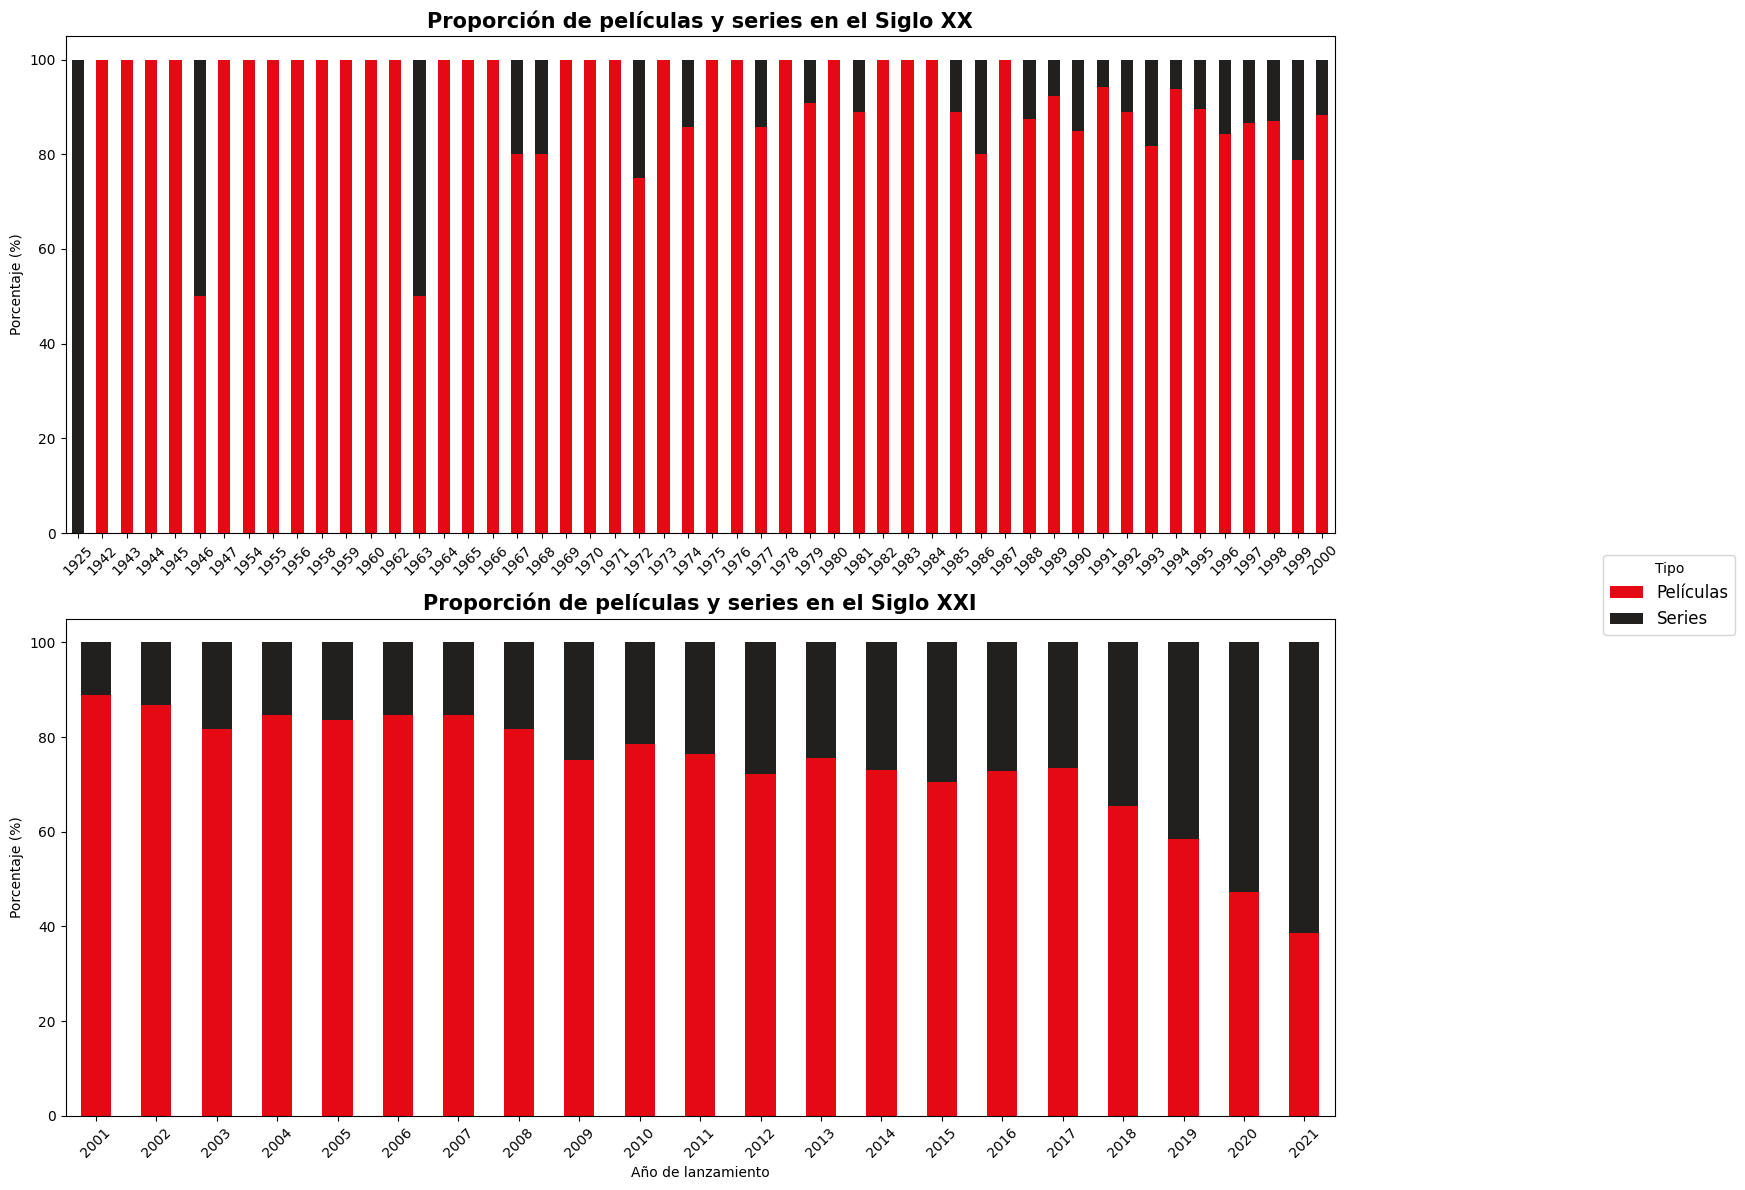

In [3]:

# Agrupar por año y tipo (Movie / TV Show)
proportion = df.groupby(['release_year', 'type']).size().unstack(fill_value=0)

# Calcular proporción en porcentaje
proportion_percent = proportion.div(proportion.sum(axis=1), axis=0) * 100

# Colores
colors = ['#e50914', '#221f1f']

# Separar siglos
proportion_20 = proportion_percent.loc[proportion_percent.index <= 2000]
proportion_21 = proportion_percent.loc[proportion_percent.index > 2000]

# Crear subplots
fig, axes = plt.subplots(2, 1, figsize=(16,12), sharey=True)

# Siglo XX
proportion_20.plot(kind="bar", stacked=True, color=colors, ax=axes[0])
axes[0].set_title("Proporción de películas y series en el Siglo XX", fontsize=15, fontweight="bold")
axes[0].set_ylabel("Porcentaje (%)")
axes[0].set_xlabel("")
axes[0].tick_params(axis="x", rotation=45)
axes[0].legend_.remove()  # quitar leyenda individual

# Siglo XXI
proportion_21.plot(kind="bar", stacked=True, color=colors, ax=axes[1])
axes[1].set_title("Proporción de películas y series en el Siglo XXI", fontsize=15, fontweight="bold")
axes[1].set_ylabel("Porcentaje (%)")
axes[1].set_xlabel("Año de lanzamiento")
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend_.remove()  # quitar leyenda individual

# Leyenda común a la derecha
fig.legend(title="Tipo", labels=["Películas", "Series"], loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)

# Ajustar espacio para la leyenda
plt.tight_layout(rect=[0,0,0.85,1])
plt.show()

# Parte 2
¿Cómo evolucionó la cantidad de estrenos a lo largo del tiempo
para cada tipo de contenido?

<Figure size 1400x600 with 0 Axes>

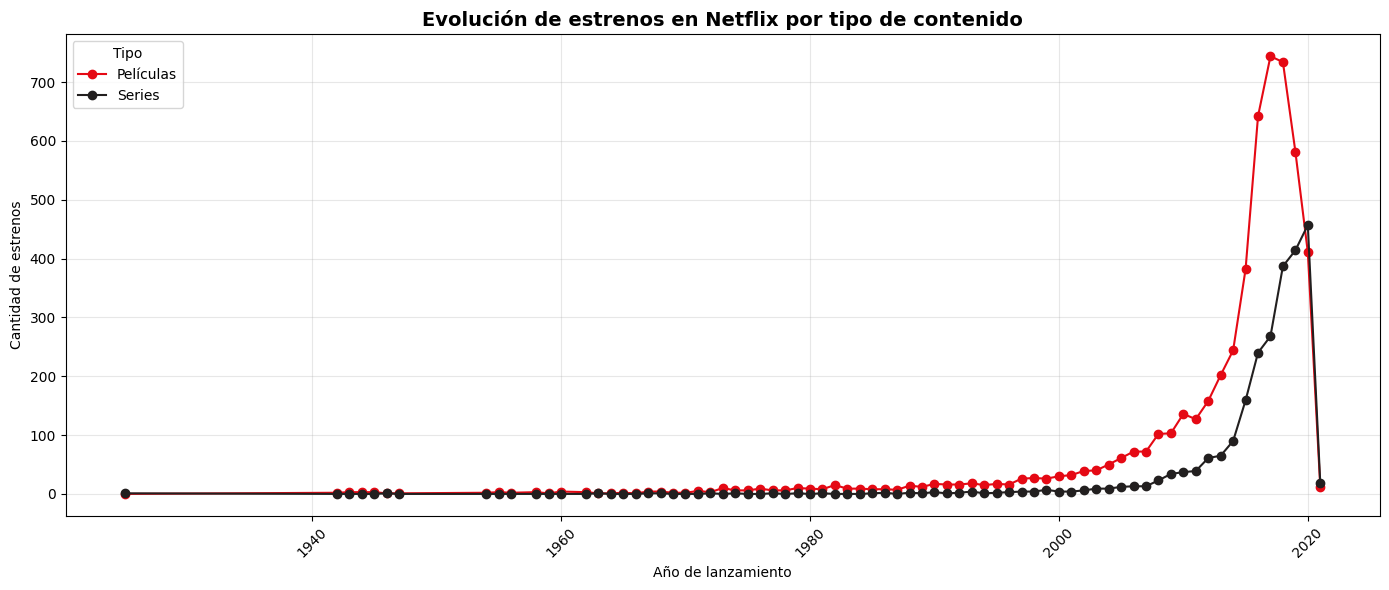

In [4]:
# Agrupar por año y tipo
releases = df.groupby(['release_year', 'type']).size().unstack(fill_value=0)


colors = ['#e50914', '#221f1f']  # Rojo Netflix y negro

# Graficar evolución
plt.figure(figsize=(14,6))
releases.plot(kind="line", marker="o", color=colors, figsize=(14,6))

# Títulos y etiquetas
plt.title("Evolución de estrenos en Netflix por tipo de contenido", fontsize=14, fontweight="bold")
plt.ylabel("Cantidad de estrenos")
plt.xlabel("Año de lanzamiento")

# Leyenda
plt.legend(title="Tipo", labels=["Películas", "Series"], loc="upper left")

# Ajuste final
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Parte 3
¿Cuáles son los países con más producciones? ¿Se destacan
más por películas o series?

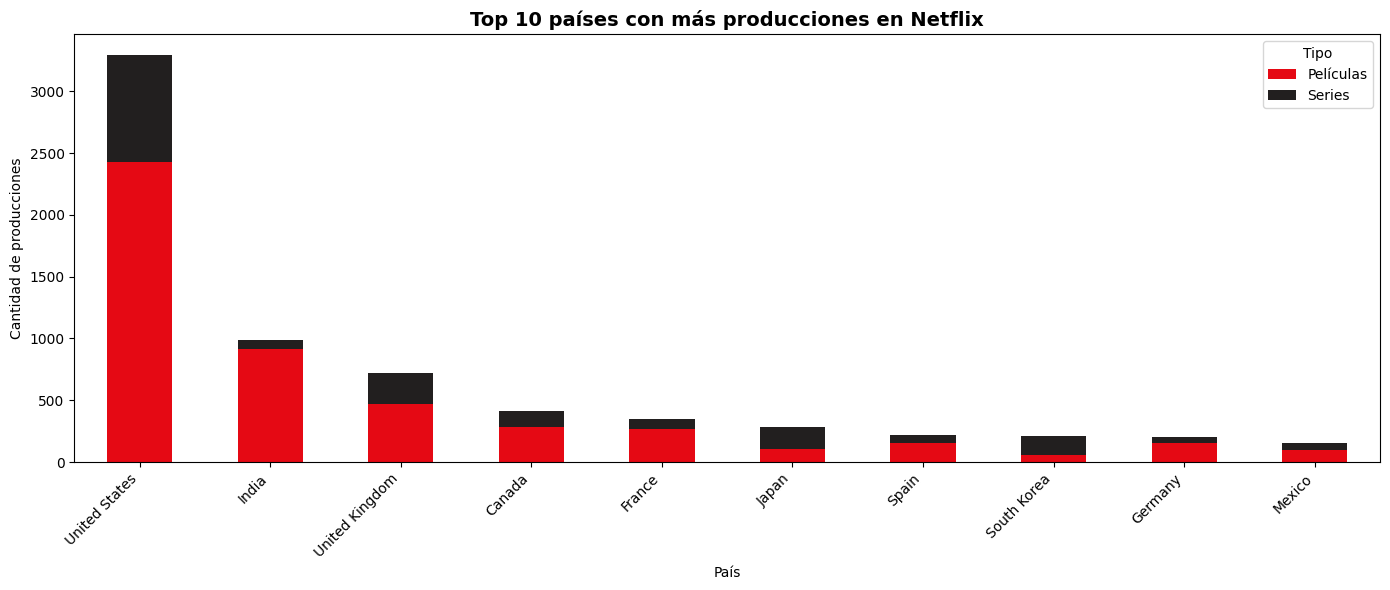

In [5]:
# Dividir múltiples países (algunas filas tienen varios separados por coma)
df['country_split'] = df['country'].str.split(", ")
df_explode = df.explode('country_split')

# Agrupar por país y tipo de contenido
country_counts = df_explode.groupby(['country_split', 'type']).size().unstack(fill_value=0)

# Seleccionar los 10 países con más producciones
top_countries = country_counts.sum(axis=1).sort_values(ascending=False).head(10)
top_countries_data = country_counts.loc[top_countries.index]

# Paleta de colores sugerida
colors = ['#e50914', '#221f1f']

# Gráfico de barras apiladas
top_countries_data.plot(kind="bar", stacked=True, figsize=(14,6), color=colors)

# Títulos y etiquetas
plt.title("Top 10 países con más producciones en Netflix", fontsize=14, fontweight="bold")
plt.ylabel("Cantidad de producciones")
plt.xlabel("País")

# Leyenda
plt.legend(title="Tipo", labels=["Películas", "Series"], loc="upper right")

# Ajustes finales
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Parte 4
¿Qué tipo de contenido es más común para cada rating?

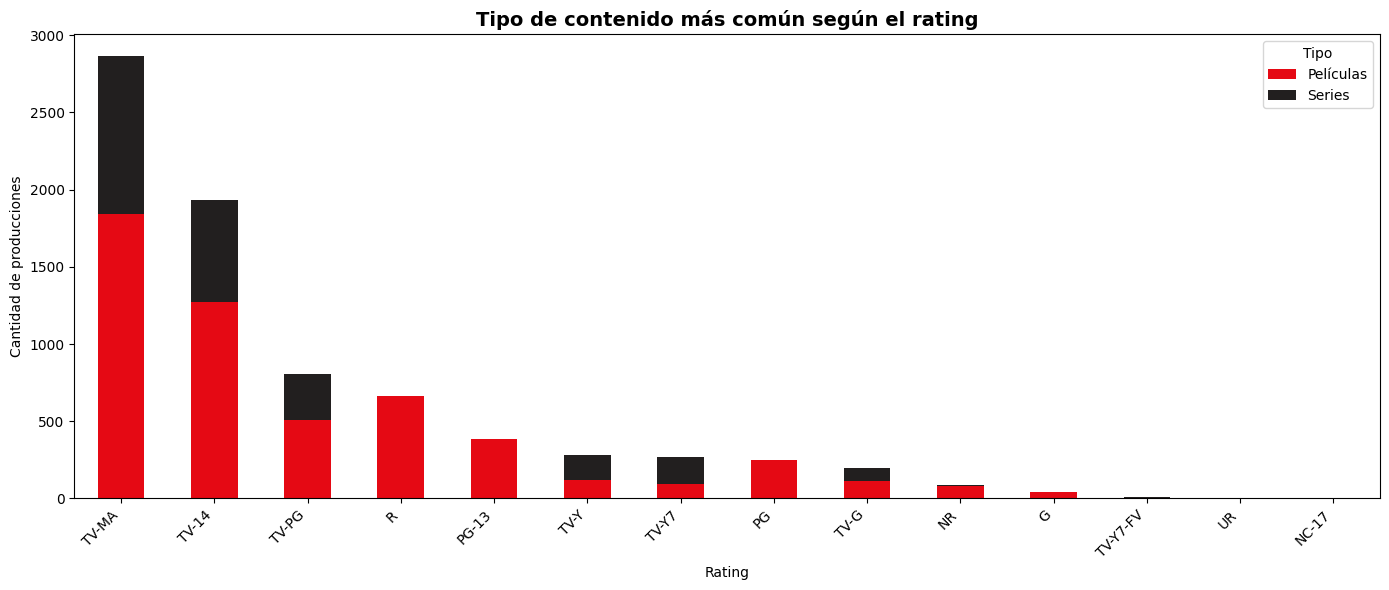

In [6]:
# Agrupar por rating y tipo
rating_counts = df.groupby(['rating', 'type']).size().unstack(fill_value=0)

# Ordenar por total de producciones
rating_counts = rating_counts.loc[rating_counts.sum(axis=1).sort_values(ascending=False).index]

# Paleta de colores
colors = ['#e50914', '#221f1f']

# Gráfico de barras apiladas
rating_counts.plot(kind="bar", stacked=True, figsize=(14,6), color=colors)

# Títulos y etiquetas
plt.title("Tipo de contenido más común según el rating", fontsize=14, fontweight="bold")
plt.ylabel("Cantidad de producciones")
plt.xlabel("Rating")

# Leyenda
plt.legend(title="Tipo", labels=["Películas", "Series"], loc="upper right")

# Ajustes finales
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Parte 5
¿Qué países producen más contenido para audiencias adultas e
infantiles? ¿Se les ocurre otra separación además de estas dos?

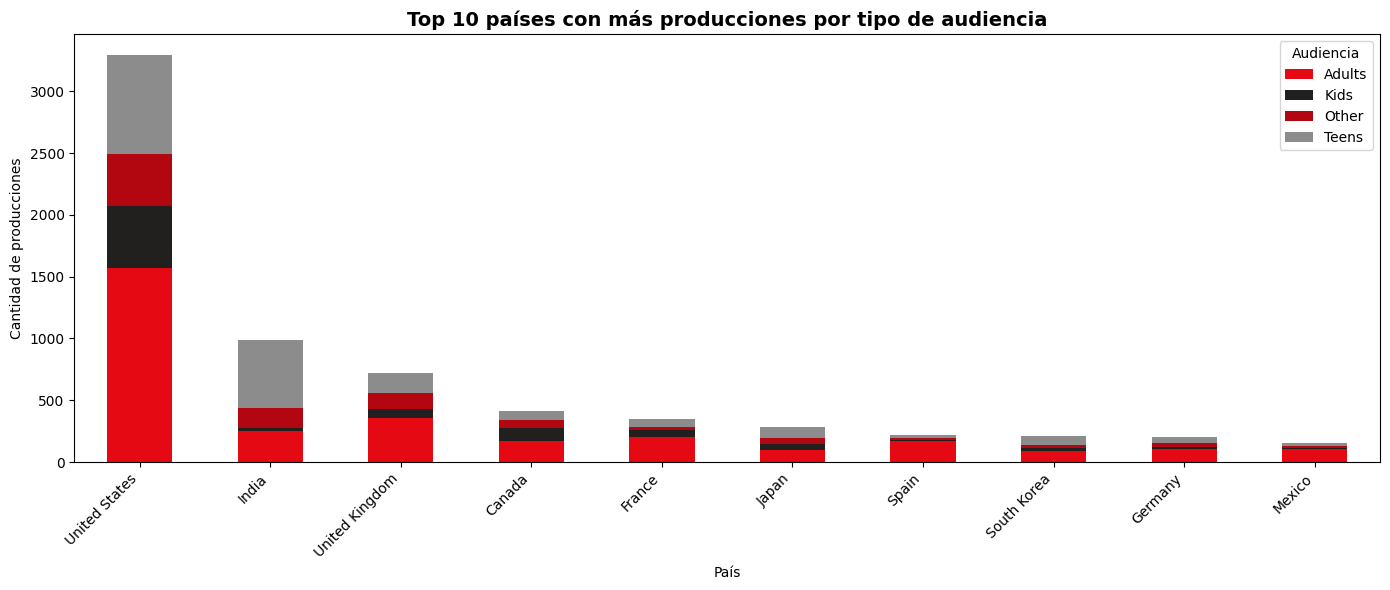

In [7]:
# Definir clasificación de audiencias
audience_map = {
    "Kids": ["TV-Y", "TV-Y7", "G", "PG"],
    "Teens": ["PG-13", "TV-14"],
    "Adults": ["R", "NC-17", "TV-MA"]
}

def classify_audience(rating):
    for key, values in audience_map.items():
        if rating in values:
            return key
    return "Other"

df["audience"] = df["rating"].apply(classify_audience)

# Expandir países (varios por fila)
df["country_split"] = df["country"].str.split(", ")
df_explode = df.explode("country_split")

# Agrupar por país y audiencia
audience_country = df_explode.groupby(["country_split", "audience"]).size().unstack(fill_value=0)

# Seleccionar los 10 países con más producciones
top_countries = audience_country.sum(axis=1).sort_values(ascending=False).head(10)
top_audience_data = audience_country.loc[top_countries.index]

# Paleta de colores
colors = ['#e50914', '#221f1f', '#b20710', '#8c8c8c']  # rojo Netflix, negro y bordo y agregamos un gris que no etsaba en la gama de colores porque no se visualisaba en blanco

# Gráfico de barras apiladas
top_audience_data.plot(kind="bar", stacked=True, figsize=(14,6), color=colors)

# Títulos y etiquetas
plt.title("Top 10 países con más producciones por tipo de audiencia", fontsize=14, fontweight="bold")
plt.ylabel("Cantidad de producciones")
plt.xlabel("País")

# Leyenda
plt.legend(title="Audiencia")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Parte 6
¿Se identifica alguna estacionalidad en los estrenos según la
categoría (listed in)? Qué meses concentran más lanzamientos?

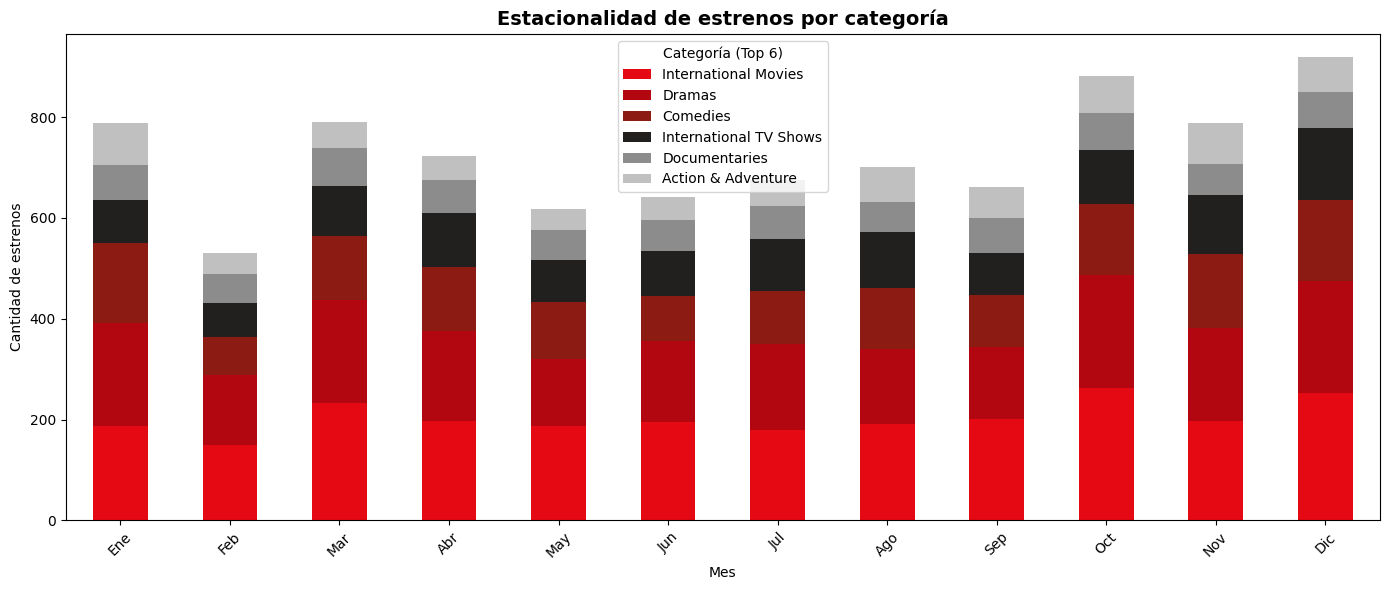

In [8]:

# Extraer mes de estreno
df['month_added'] = pd.to_datetime(df['date_added'], errors="coerce").dt.month

# Expandir categorías (puede haber varias en listed_in separadas por coma)
df['listed_split'] = df['listed_in'].str.split(", ")
df_explode = df.explode('listed_split')

# Agrupar por mes y categoría
monthly_releases = df_explode.groupby(['month_added', 'listed_split']).size().unstack(fill_value=0)

# Ordenar meses de 1 a 12
monthly_releases = monthly_releases.sort_index()

# Paleta de 6 colores Netflix-style
colors = ["#e50914", "#b20710","#8c1c13", "#221f1f", "#8c8c8c", "#c0c0c0"]

# Seleccionar las 6 categorías más frecuentes
top_categories = monthly_releases.sum().sort_values(ascending=False).head(6).index
monthly_top = monthly_releases[top_categories]

# Gráfico de barras apiladas
monthly_top.plot(kind="bar", stacked=True, figsize=(14,6), color=colors)

# Títulos y etiquetas
plt.title("Estacionalidad de estrenos por categoría", fontsize=14, fontweight="bold")
plt.ylabel("Cantidad de estrenos")
plt.xlabel("Mes")
plt.xticks(range(12), 
           ["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"], 
           rotation=45)

# Leyenda
plt.legend(title="Categoría (Top 6)")
plt.tight_layout()
plt.show()

# Parte 7
¿Qué directores tienen más títulos? ¿Se concentran en algún tipo de contenido o en una audiencia específica?

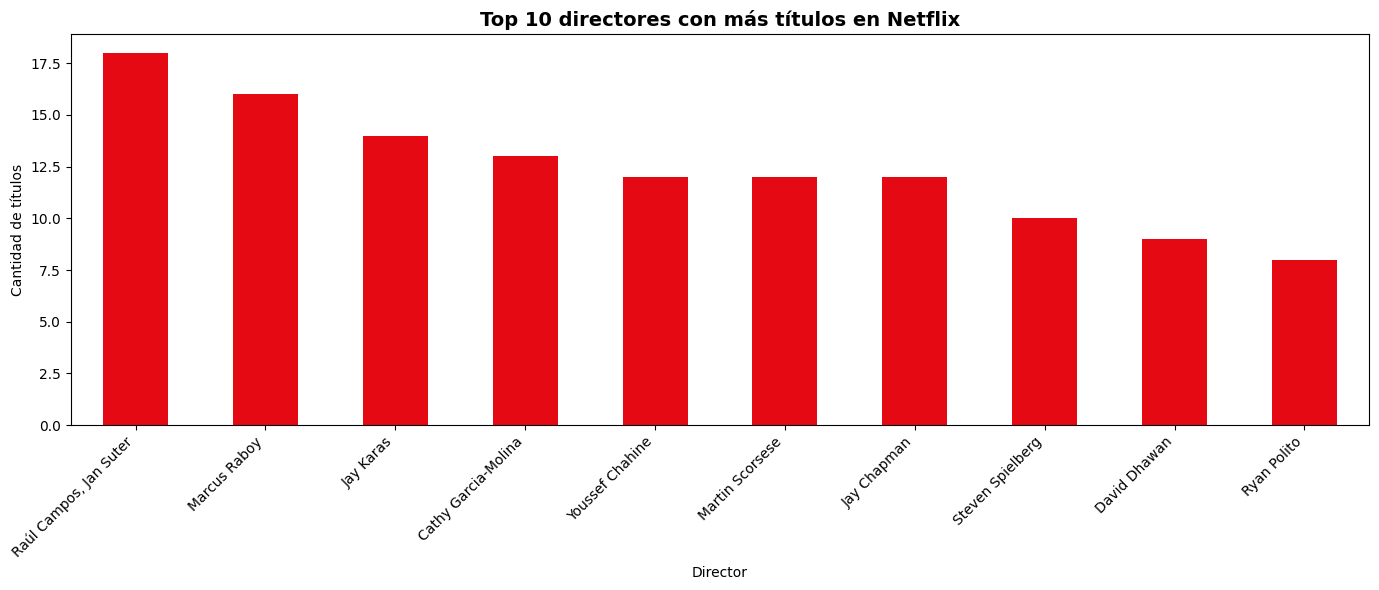

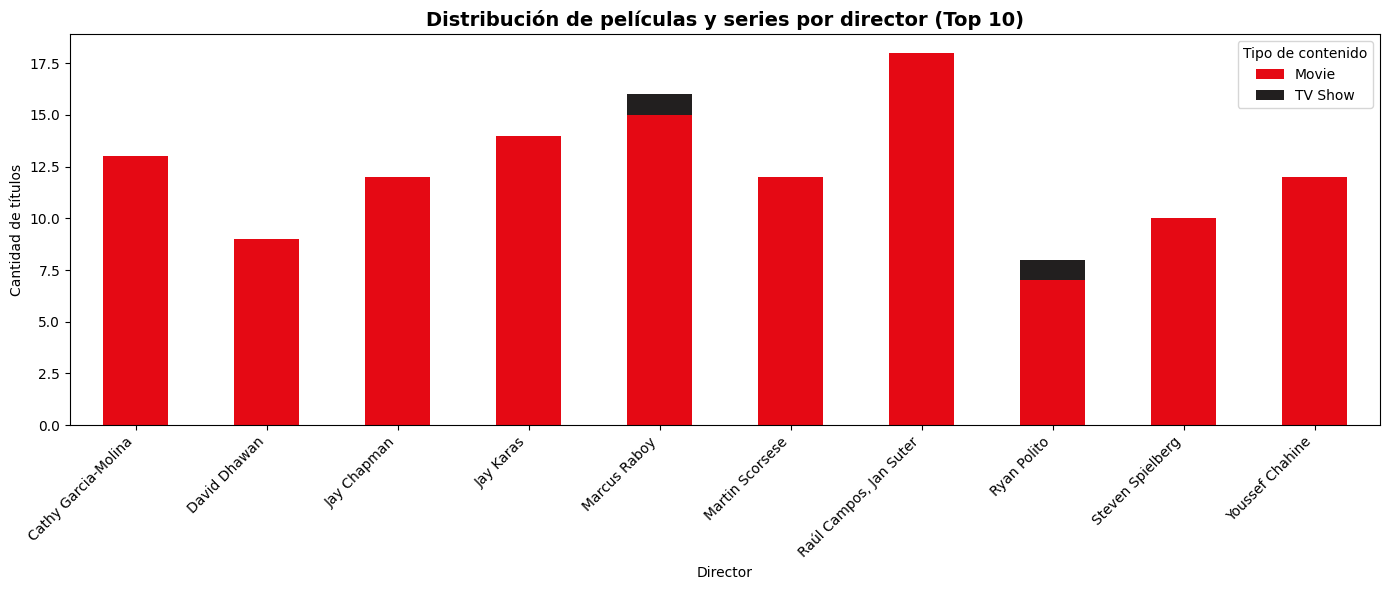

In [9]:

# Usamos la clasificación de audiencias (si no existe, crearla otra vez)
audience_map = {
    "Kids": ["TV-Y", "TV-Y7", "G", "PG"],
    "Teens": ["PG-13", "TV-14"],
    "Adults": ["R", "NC-17", "TV-MA"]
}

def classify_audience(rating):
    for key, values in audience_map.items():
        if rating in values:
            return key
    return "Other"

df["audience"] = df["rating"].apply(classify_audience)

# Filtrar directores válidos
df_directors = df[df["director"] != "Unknown"]

# Contar títulos por director
top_directors = df_directors["director"].value_counts().head(10)

# Extraer los datos del top 10
df_top_directors = df_directors[df_directors["director"].isin(top_directors.index)]

# Agrupar por director y tipo de contenido
director_content = df_top_directors.groupby(["director", "type"]).size().unstack(fill_value=0)

# Paleta de 6 colores Netflix-style
colors = ["#e50914", "#b20710", "#8c1c13", "#221f1f", "#444444", "#c0c0c0"]

# --- Gráfico 1: Top 10 directores por cantidad de títulos ---
plt.figure(figsize=(14,6))
top_directors.plot(kind="bar", color=colors[0])
plt.title("Top 10 directores con más títulos en Netflix", fontsize=14, fontweight="bold")
plt.ylabel("Cantidad de títulos")
plt.xlabel("Director")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- Gráfico 2: Distribución entre películas y series para el top 10 ---
director_content.plot(kind="bar", stacked=True, figsize=(14,6), color=[colors[0], colors[3]])
plt.title("Distribución de películas y series por director (Top 10)", fontsize=14, fontweight="bold")
plt.ylabel("Cantidad de títulos")
plt.xlabel("Director")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Tipo de contenido")
plt.tight_layout()
plt.show()

# Parte 8
¿Cuáles son los actores más populares?


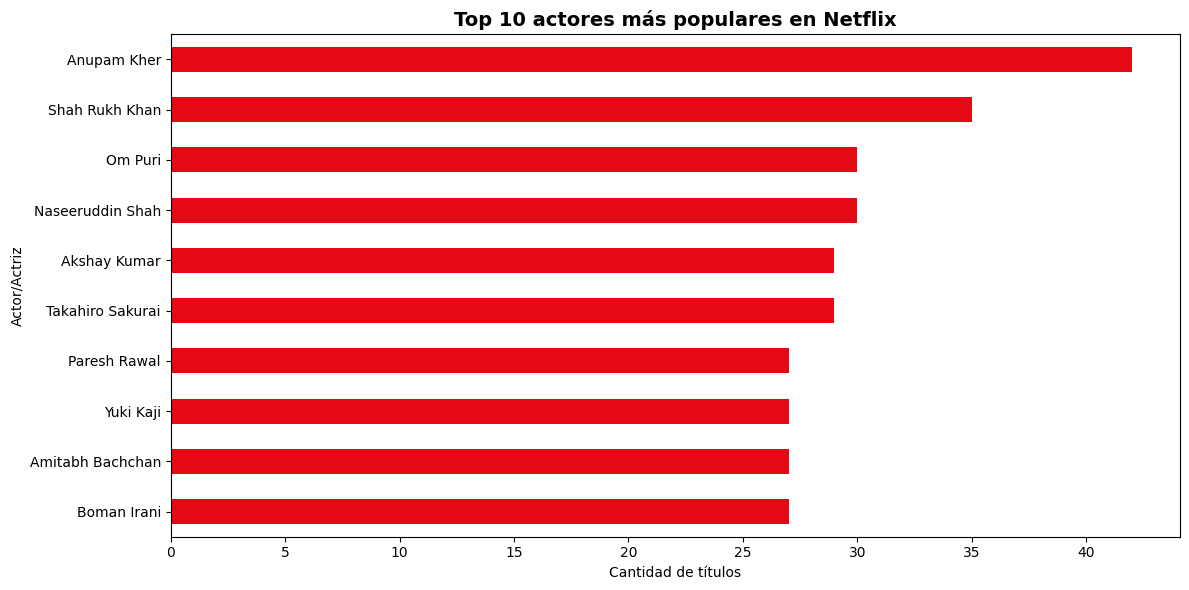

In [10]:
# Filtrar actores válidos
df_actors = df[df["cast"] != "Unknown"].copy()

# Separar múltiples actores
df_actors["cast_split"] = df_actors["cast"].str.split(", ")
df_explode_actors = df_actors.explode("cast_split")

# Contar frecuencia de actores
top_actors = df_explode_actors["cast_split"].value_counts().head(10)

# Paleta Netflix-style (usamos un solo color fuerte)
colors = ["#e50914"]

# Gráfico de barras horizontales
plt.figure(figsize=(12,6))
top_actors.sort_values().plot(kind="barh", color=colors[0])

# Títulos y etiquetas
plt.title("Top 10 actores más populares en Netflix", fontsize=14, fontweight="bold")
plt.xlabel("Cantidad de títulos")
plt.ylabel("Actor/Actriz")

plt.tight_layout()
plt.show()

# Parte 9
¿Cuál es la distribución en duración en series y películas?

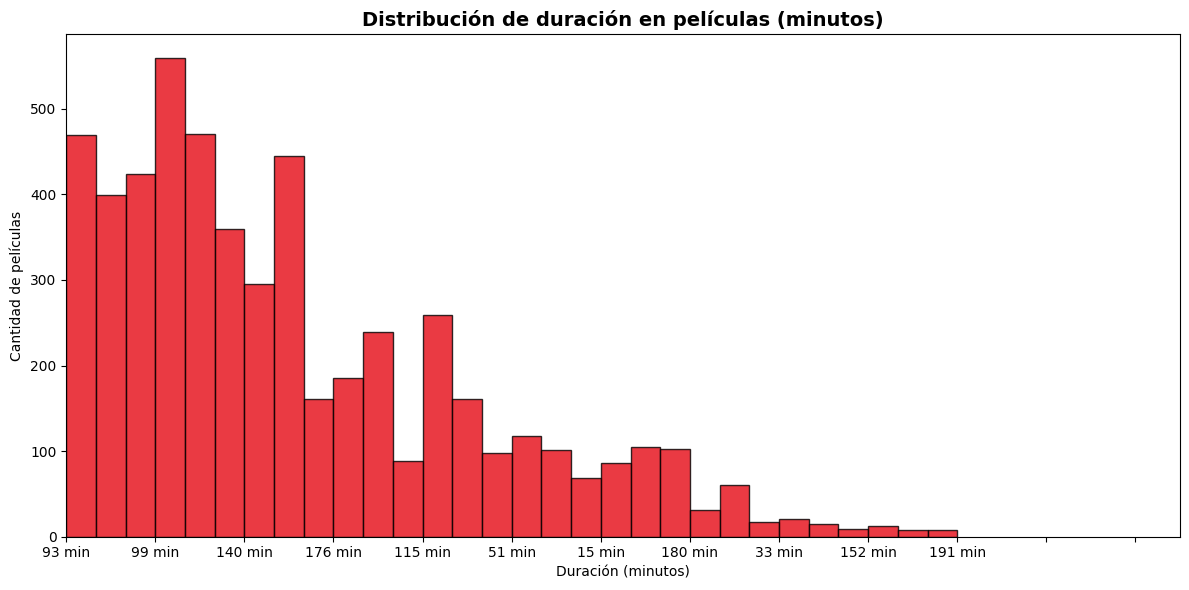

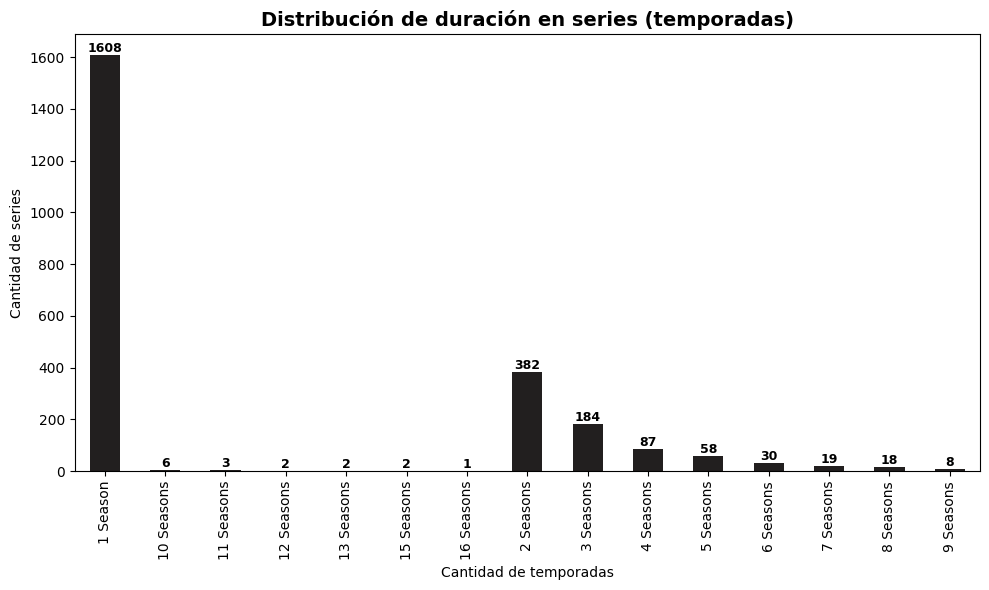

In [11]:
# --- Películas ---
movies = df[df["type"] == "Movie"]["duration"].dropna()

plt.figure(figsize=(12,6))
plt.hist(movies, bins=30, color="#e50914", edgecolor="black", alpha=0.8)

plt.title("Distribución de duración en películas (minutos)", fontsize=14, fontweight="bold")
plt.xlabel("Duración (minutos)")
plt.ylabel("Cantidad de películas")

# Ajustar rango de eje x para evitar solapamiento (ej: hasta 250 min)
plt.xlim(0, 250)
plt.xticks(range(0, 251, 20))  # ticks cada 20 minutos

plt.tight_layout()
plt.show()

# --- Series ---
series = df[df["type"] == "TV Show"]["duration"].dropna()

plt.figure(figsize=(10,6))
ax = series.value_counts().sort_index().plot(kind="bar", color="#221f1f")

plt.title("Distribución de duración en series (temporadas)", fontsize=14, fontweight="bold")
plt.xlabel("Cantidad de temporadas")
plt.ylabel("Cantidad de series")

# Agregar etiquetas arriba de cada barra
for p in ax.patches:
    value = int(p.get_height())
    ax.annotate(str(value),
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9, fontweight="bold")

plt.tight_layout()
plt.show()

# Parte 10
¿Hay palabras que se utilicen más que otras en títulos y descripciones?

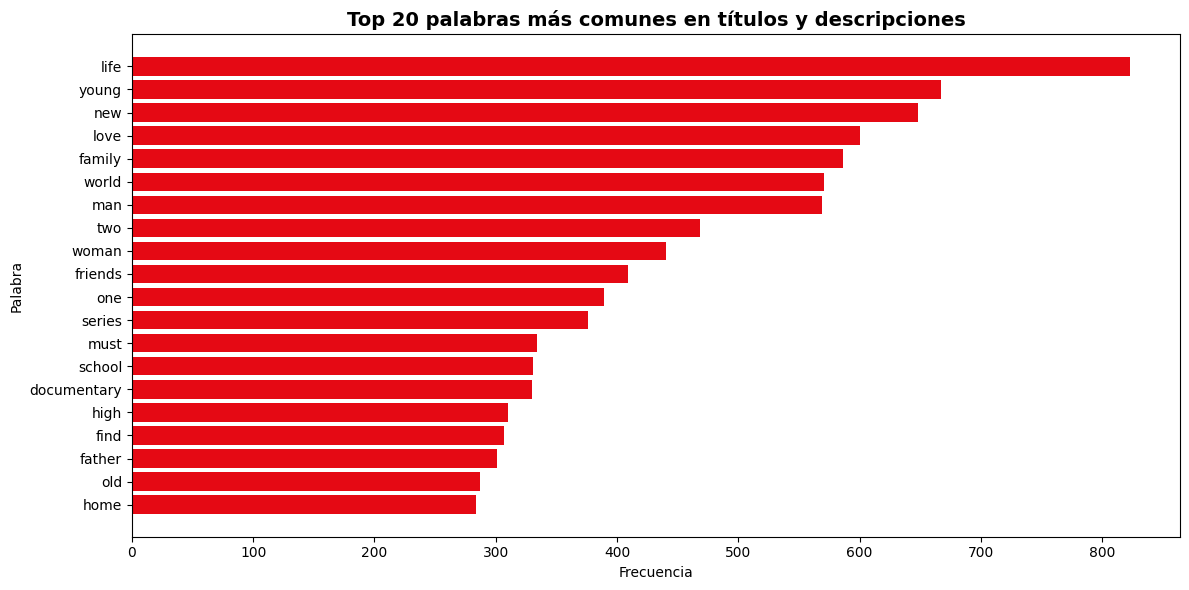

In [12]:
import re
from collections import Counter


# Cargar stopwords desde archivo
with open("stop_words.txt", "r") as f:
    stop_words = set([w.strip() for w in f.readlines()])

# Unir títulos y descripciones
text = (df["title"].astype(str) + " " + df["description"].astype(str)).str.lower()

# Tokenizar y limpiar texto
words = []
for line in text:
    tokens = re.findall(r"\b[a-zA-ZáéíóúñüÁÉÍÓÚÑÜ]+\b", line)  # solo palabras
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]  # quitar stopwords y palabras cortas
    words.extend(tokens)

# Contar frecuencia
counter = Counter(words)
top_words = counter.most_common(20)

# Convertir a DataFrame
top_df = pd.DataFrame(top_words, columns=["Palabra", "Frecuencia"])

# Gráfico
plt.figure(figsize=(12,6))
plt.barh(top_df["Palabra"], top_df["Frecuencia"], color="#e50914")
plt.gca().invert_yaxis()  # la más frecuente arriba
plt.title("Top 20 palabras más comunes en títulos y descripciones", fontsize=14, fontweight="bold")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.tight_layout()
plt.show()